In [1]:
import cv2
import numpy as np
from numpy.core.numeric import True_
from numpy.lib.arraysetops import unique
import pandas as pd
import glob
import os
import json
import datetime
import matplotlib.pyplot as plt


make_video = False
dataset_dir_path = '../datasets/au-air/'
save_path = './tmp/'
annotations_path = dataset_dir_path + 'auair2019annotations/'
image_path = dataset_dir_path + 'auair2019data/images/'
annotations_file = dataset_dir_path + 'annotations_v1.1.json'
video_max_frames = 2000

video_ext = '.avi'
image_ext = '.jpg'
image_files = image_path + '*' + image_ext


In [2]:
# def AddDateTime(names):
#     s = pd.Series(names.str.split('_'))
#     df_tmp = pd.DataFrame(s.tolist(), columns=['head', 'time', 'x', 'id.jpg'])
#     s = pd.Series(df_tmp['id.jpg'].str.split('.'))
#     df_tmp2 = pd.DataFrame(s.tolist(), columns=['id', 'jpg'])
#     df_full['time'] = df_tmp['time']
#     df_full['id'] = df_tmp2['id']
#     df_full.set_index('image_name')

## Creating annotations dataframe

In [3]:
# using annotations:
print("Loading annotations...")
data = json.load((open(annotations_file)))
df_json = pd.json_normalize(data, 'annotations').sort_values(by=['image_name','time.ms'])
# df_bbox = pd.json_normalize(
#     data, ['annotations', 'bbox'])
# print()
# # print(data.keys())
categoriesDict = data['categories']
# print(len(df_json), len(df_bbox))
# print(df_bbox)
print(
    f'Number for annotation duplicates is {df_json.image_name.duplicated().sum()}')


Loading annotations...
Number for annotation duplicates is 0


## Creating Image Dataframe

In [4]:


# df_json_date = df_json[df_json['image_name'].str.contains(search_date)]

# using images:
print("Finding image names...")
files = np.array(glob.glob(image_files))
df_imgs = pd.concat([pd.DataFrame([os.path.basename(file)], columns=['image_name']) for file in files],
                    ignore_index=True)
df_imgs['full_path'] = files
s = pd.Series(df_imgs['image_name'].str.split('_'))
df_tmp = pd.DataFrame(s.tolist(), columns=['head', 'short_name', 'x', 'id.jpg'])
s = pd.Series(df_tmp['id.jpg'].str.split('.'))
df_tmp2 = pd.DataFrame(s.tolist(), columns=['id', 'jpg'])
df_imgs['short_name'] = df_tmp['short_name']
df_imgs['id'] = df_tmp2['id']
df_imgs.set_index('image_name')
print(
    f'Number for image duplicates is {df_imgs.image_name.duplicated().sum()}')

# df_imgs = df_imgs.sort_values(by=['time', 'id']).drop_duplicates(
#     subset=['time', 'id'])
# year = df_json['time.year']
# month = df_json['time.month']
# day = df_json['time.day']
# min = df_json['time.min']
# sec = df_json['time.sec']
# msec = df_json['time.ms']
# print(year.values)
# df_json['datetime'] = pd.Timestamp(
#     str(year.values) + '-' + str(month.values) + '-' + str(day.values))
# # 'time.year', 'time.month', 'time.day', 'time.hour', 'time.min', 'time.sec')

# print(df_json['datetime'])


Finding image names...
Number for image duplicates is 0


## Merging dataframes

Date grouping: /n
time.year  time.month  time.day  time.hour  time.min  time.sec
2019       8           29        9          11        11          2592
           9           5         9          17        50          5734
                                 10         31        12          6840
                                 11         19        47           771
                                            25        22          5358
                                 14         21        19          2962
                                            35        5           1580
                       6         15         7         31          6986
dtype: int64


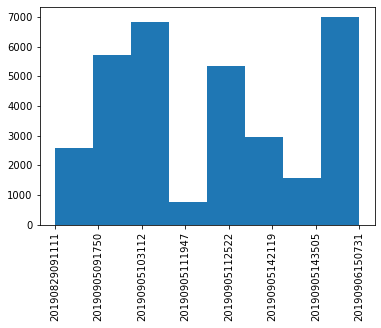

In [5]:
df_full = pd.merge(df_json, df_imgs, how='inner', on='image_name')
df_grp = df_full.groupby(
    by=['time.year', 'time.month', 'time.day', 'time.hour', 'time.min', 'time.sec'])
print("Date grouping: /n")
print(df_grp.size())


plt.hist(df_full['short_name'], bins=8)
plt.xticks(rotation = 90) 
plt.show()

## Finding number of recordings based on date

In [6]:
unique_dates = unique(df_full['short_name'])
recording_cnt = len(unique_dates)
print(f"There are {recording_cnt} video recordings:")
print(unique_dates)

There are 8 video recordings:
['20190829091111' '20190905091750' '20190905103112' '20190905111947'
 '20190905112522' '20190905142119' '20190905143505' '20190906150731']


## Create a video (if needed)

In [7]:
from video_utils import VideoUtils

vu = VideoUtils()

# Creates the video
make_video = False


# do for loop here on date
cnt = recording_cnt
for i in range(0, cnt):
    search_date = unique_dates[i]
    print('####### START #########')
    print(f'Video # {i + 1} / {cnt}')
    print(f'Selecting date: {search_date}')
    df_recording = df_full[df_full['image_name'].str.contains(search_date)]
    images = pd.Series(df_recording['full_path'].values,
                       index=df_recording['full_path'])

# Calculate Frames Per Second
    timespan_ms = df_recording['time.ms'].iloc[-1] - \
        df_recording['time.ms'].iloc[0]
    timespan_sec = timespan_ms/1000
    print(
        f'Recording duration is {timespan_sec} sec')
    fps = len(df_recording)/timespan_sec
    print(f'fps: {fps}')

    if(make_video):
        video_name = 'video_' + search_date
        if os.path.exists(video_name + video_ext):
            os.remove(video_name + video_ext)
        vu.CreateVideo(images, fps, video_name, video_ext, video_max_frames)

    print('######## END ##########')


####### START #########
Video # 1 / 8
Selecting date: 20190829091111
Recording duration is 710.8 sec
fps: 3.6465953854811484
######## END ##########
####### START #########
Video # 2 / 8
Selecting date: 20190905091750
Recording duration is 1275.4 sec
fps: 4.495844440959699
######## END ##########
####### START #########
Video # 3 / 8
Selecting date: 20190905103112
Recording duration is 1480.8 sec
fps: 4.6191247974068075
######## END ##########
####### START #########
Video # 4 / 8
Selecting date: 20190905111947
Recording duration is 156.0 sec
fps: 4.9423076923076925
######## END ##########
####### START #########
Video # 5 / 8
Selecting date: 20190905112522
Recording duration is 1201.2 sec
fps: 4.460539460539461
######## END ##########
####### START #########
Video # 6 / 8
Selecting date: 20190905142119
Recording duration is 666.4 sec
fps: 4.444777911164466
######## END ##########
####### START #########
Video # 7 / 8
Selecting date: 20190905143505
Recording duration is 624.8 sec
fps: 

In [8]:
# from video_utils import VideoUtils
# vu = VideoUtils() 
# save_dir =  './new_video_20190829091111_2/'     
# created_images_array = vu.SplitVideoToFrames(save_dir, 'video_20190829091111_2.avi')

# Construct annotated video step by step

## 1.  Video selection

In [9]:
# from video_utils import VideoUtils
# import pandas as pd
# import numpy as np

# vu = VideoUtils(categoriesDict) 

# rec_timestamp = '20190829091111' #this should be the same as unique_dates[0]
# recording_name_postfix = 2 #this should be the same as unique_dates[0]
# video_ext = '.avi'
# save_dir =  './new_video_' + rec_timestamp + '_' + str(recording_name_postfix) + '/' 
# orig_video_name =  'video_' + rec_timestamp + '_' +  str(recording_name_postfix) + video_ext
# new_video_name =  'annotated_' + rec_timestamp + '_' +  str(recording_name_postfix) + video_ext


## 2.  Split video to frames

In [10]:
# created_images_array, cnt = vu.SplitVideoToFrames(save_dir, orig_video_name)
# images = pd.Series(created_images_array)

## 3.  Find relevent annotations

In [11]:
# ##############
# # create image array from reading the actual images
# #img_array = vu.CreateImagesArray(images, len(created_images_array))
# print(rec_timestamp)
# # select the annotations that are only relevent to the current recording
# frames_cnt = len(created_images_array)
# df_recording_bbox = df_full[df_full['short_name'] == rec_timestamp][['time.ms','bbox']]
# # remove all non relevent data
# start_index = max((recording_name_postfix-1)*video_max_frames, 0)
# end_index = start_index + frames_cnt
# # print(start_index)
# # print(df_recording_bbox)
# df_bbox = df_recording_bbox.iloc[start_index:end_index]

# # print(df_bbox)

## 4. Add annotations to frames

In [12]:
# for i_img in range(len(images)):
#   frame_name = images[i_img]
#   bbox_data_for_img = df_bbox['bbox'].iloc[i_img]
#   vu.AddAllFrameAnnotations(frame_name, bbox_data_for_img, 2)

## 5.  Create video

In [13]:
# # Calculate Frames Per Second
# timespan_ms = df_bbox['time.ms'].iloc[-1] - df_bbox['time.ms'].iloc[0]
# timespan_sec = timespan_ms/1000
# fps = len(df_bbox)/timespan_sec

# if os.path.exists(new_video_name + video_ext):
#     os.remove(new_video_name + video_ext)

# vu.CreateVideo(images, fps, new_video_name, video_max_frames)

## 6. Cleanup, remove frames

In [14]:
# #clears all frames in folder
# files_in_directory = os.listdir(save_dir)
# filtered_files = [file for file in files_in_directory if file.endswith(".jpg")]
# for file in filtered_files:
# 	path_to_file = os.path.join(save_dir, file)
# 	os.remove(path_to_file)

In [20]:
from utils.video_utils import VideoUtils
# from video_utils import DirectoryUtils
import pandas as pd
import numpy as np

vUtils = VideoUtils() 
drUtils = DirectoryUtils()

rec_timestamp = '20190905112522' #this should be the same as unique_dates[0]
recording_name_postfix = 2 #this should be the same as unique_dates[0]
video_ext = '.avi'
save_dir =  './new_video_' + rec_timestamp + '_' + str(recording_name_postfix) + '/' 
orig_video_name =  'video_' + rec_timestamp + '_' +  str(recording_name_postfix) + video_ext
new_video_name =  'annotated_' + rec_timestamp + '_' +  str(recording_name_postfix) + video_ext
video_max_frames = 2000

start_index = max((recording_name_postfix-1)*video_max_frames, 0)
end_index = start_index + video_max_frames
df_bbox = df_full[df_full['short_name'] == rec_timestamp][['bbox']].iloc[start_index:end_index]
start_time = 0
video_duration=None
# vUtils.AnnotateVideo(save_dir, orig_video_name, new_video_name, df_bbox['bbox'].to_numpy(), 30, 2000)
gt_video_out, bbox_gt = vUtils.AnnotateVideo(save_dir, orig_video_name, new_video_name, df_bbox, start_time, video_duration)

drUtils.ClearFileType(save_dir,".jpg")

FileNotFoundError: [WinError 3] The system cannot find the path specified: './new_video_20190905112522_2/'

In [ ]:
# import datashader as ds
# import pandas as pd
# import colorcet
# # df  = pd.read_csv('census.csv')
# cvs = ds.Canvas(plot_width=850, plot_height=500)
# agg = cvs.points(df_json, 'longitude', 'latitude')
# img = ds.tf.shade(agg, cmap=colorcet.fire, how='log')